In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import KFold

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML
from datetime import datetime
from langdetect import detect
import re
import copy

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.4.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

In [8]:
MODEL_NAME = "https://tfhub.dev/google/nnlm-en-dim50/2"

## GET DATA

In [9]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [10]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [11]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '223040',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/A7IOpPt-lHrMYsbRmxXWdQ__thumb/img/XoD3fXgApfY7-dfYyFeE6FVkbfY=/fit-in/200x150/filters:strip_icc()/pic6177962.jpg',
  'name': 'Fantasy Realms',
  'yearpublished': '2017'},
 {'id': '326494',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/OcnPGq9DYBKJO_dJ0JVKNQ__thumb/img/22Z6VwHfOQRKaEIHdm0xiaHNua0=/fit-in/200x150/filters:strip_icc()/pic5986451.jpg',
  'name': 'The Adventures of Robin Hood',
  'yearpublished': '2021'}]

In [12]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,223040,4rch3r,8.5,"""301 ist maximale Punktzahl"""
1,223040,9zero21zero,8.0,Sleeved - Mayday 7077
2,223040,Abdul,6.0,Maths homework disguised as a game. It's fine ...
3,223040,absolutleo,8.0,My wife tries to veto a 10 - so 9 is a comprom...
4,223040,Adam78,9.0,This is great. One of the simplest rulesets go...
...,...,...,...,...
90402,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
90403,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
90404,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
90405,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [13]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [14]:
comments_df["value"] = comments_df["value"].astype(str)

In [15]:
# REMOVE URLs FROM COMMENTS

In [16]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [17]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [18]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15377 for 'remove_short_comments' - min len: 25 - method: unrated


In [19]:
# REMOVE NON ENGLISH COMMENTS

In [20]:
# !conda install -c conda-forge langdetect

In [21]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [22]:
# comments_df = add_comments_lang(comments_df)

In [23]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [24]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10.0      14834
9.0       14016
8.0       11723
7.0        6434
N/A        6407
          ...  
7.34          1
7.12          1
8.5711        1
8.026         1
8.5462        1
Name: rating, Length: 523, dtype: int64

In [25]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(68623, 5)

In [26]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6407, 5)

## CREATE TRAINING AND VALIDATION DATA

In [27]:
# use rated comments (reviews) to train the model

In [28]:
rated_comments = rated_comments.sample(frac=1)

In [29]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [30]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"Wow, just wow. The only bad thing about this is the setup time. Everything has been written about the game before. Yes, it's really THAT good!"

In [31]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'The Crew is a puzzle-based cooperative trick taking game. Each round is self-contained. The only carryover is the inner-workings of the players. It is all about challenging a group with a puzzle, solving it, then moving on to the next one. The puzzles capture key moments in trick-taking very well--trump timing, protecting nils, bidding tricks, "taking someone home." Through, in a cooperative environment, seizing the moment looses some of its luster. When everyone works together to protect a bid, their is no ongoing challenge to bust another player nor is there the reward of keeping an opponent from busting a partner\'s nil bid.  What it does to very well, though, is capitalizing on partners\' getting on the same wavelength in a trick taking game. This is where the game excels. The Crew doesn\'t reach the loft heights of team vs. team trick takers like Spades, but serves as an engaging way to challenge the table to a series of bite-sized, mutual puzzles for fans of the genre.'

## COMPOSE MODEL

In [32]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

In [33]:
def build_model(hub_layer=None, model_type='classifier', lstm=False, verbose=1):    
    if hub_layer is None:
        hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)
        
    if model_type not in ('classifier', 'regressor'):
        raise AttributeError("model type can only be 'classifier' or 'regressor'")

    if verbose:
        print("example of layers processing:")
        print(hub_layer(train_examples[:2]))
        print("")

    if model_type == 'classifier':
        model = tf.keras.Sequential()
        model.add(copy.copy(hub_layer))
        if lstm:
            raise NotImplementedError("lstm = True is not implemented")
        else:
            model.add(tf.keras.layers.Dense(16, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        if verbose:
            print("model summary:")
            print(model.summary())
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
        )
    else:
        model = tf.keras.Sequential()
        model.add(copy.copy(hub_layer))
        if lstm:
            raise NotImplementedError("lstm = True is not implemented")
        else:
            model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
        model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
        
        if verbose:
            print("model summary:")
            print(model.summary())
            
        model.compile(
            loss='mean_squared_error', 
            optimizer='adam',
            metrics=["mean_squared_error"]
        )
    
    return model

## CLASSIFIER

In [34]:
def build_classifier():
    return build_model(hub_layer=None, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=512, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
68/68 - 5s - loss: 0.4826 - accuracy: 0.8489 - val_loss: 0.4044 - val_accuracy: 0.8454
Epoch 2/100
68/68 - 3s - loss: 0.3508 - accuracy: 0.8508 - val_loss: 0.3401 - val_accuracy: 0.8490
Epoch 3/100
68/68 - 3s - loss: 0.2918 - accuracy: 0.8678 - val_loss: 0.3247 - val_accuracy: 0.8654
Epoch 4/100
68/68 - 3s - loss: 0.2523 - accuracy: 0.8950 - val_loss: 0.3169 - val_accuracy: 0.8758
Epoch 5/100
68/68 - 3s - loss: 0.2168 - accuracy: 0.9130 - val_loss: 0.3256 - val_accuracy: 0.8753
Epoch 6/100
68/68 - 3s - loss: 0.1889 - accuracy: 0.9257 - val_loss: 0.3382 - val_accuracy: 0.8711
Epoch 7/100
68/68 - 3s - loss: 0.1654 - accuracy: 0.9382 - val_loss: 0.3584 - val_accuracy: 0.8646
Epoch 8/100
68/68 - 3s - loss: 0.1459 - accuracy: 0.9470 - val_loss: 0.3859 - val_accuracy: 0.8584
Epoch 9/100
68/68 - 3s - loss: 0.1303 - accuracy: 0.9537 - val_loss: 0.4178 - val_accuracy: 0.8563
45/45 - 0s - loss: 0.4204 - accuracy: 0.8603
Epoch 1/100
68/68 - 4s - loss: 0.5532 - accuracy: 0.7851 - val_l

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x0000026B8D030940>
Traceback (most recent call last):
  File "C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  File "C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\eager\function.py", l

45/45 - 0s - loss: 0.3739 - accuracy: 0.8692
Epoch 1/100
101/101 - 6s - loss: 0.4918 - accuracy: 0.8394 - val_loss: 0.3965 - val_accuracy: 0.8483
Epoch 2/100
101/101 - 5s - loss: 0.3354 - accuracy: 0.8659 - val_loss: 0.3183 - val_accuracy: 0.8732
Epoch 3/100
101/101 - 5s - loss: 0.2704 - accuracy: 0.8917 - val_loss: 0.3044 - val_accuracy: 0.8808
Epoch 4/100
101/101 - 5s - loss: 0.2323 - accuracy: 0.9083 - val_loss: 0.3086 - val_accuracy: 0.8812
Epoch 5/100
101/101 - 5s - loss: 0.2035 - accuracy: 0.9205 - val_loss: 0.3181 - val_accuracy: 0.8787
Epoch 6/100
101/101 - 5s - loss: 0.1812 - accuracy: 0.9301 - val_loss: 0.3392 - val_accuracy: 0.8759
Epoch 7/100
101/101 - 5s - loss: 0.1624 - accuracy: 0.9392 - val_loss: 0.3579 - val_accuracy: 0.8732
Epoch 8/100
101/101 - 5s - loss: 0.1475 - accuracy: 0.9461 - val_loss: 0.3795 - val_accuracy: 0.8674


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000026BB405DA90>,
             param_grid={})

In [35]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [36]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

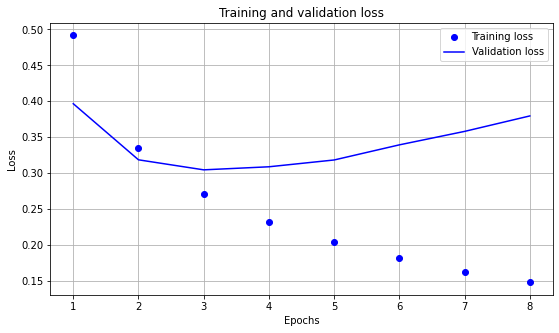

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

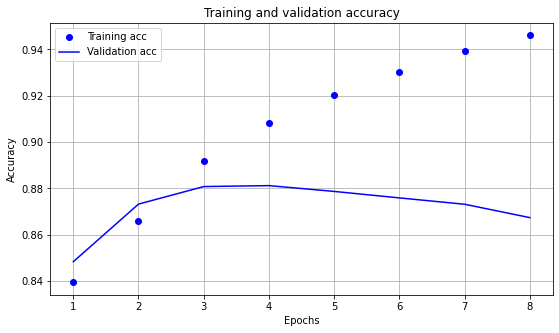

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [47]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"The Crew is a puzzle-based cooperative trick taking game. Each round is self-contained. The only carryover is the inner-workings of the players. It is all about challenging a group with a puzzle, solving it, then moving on to the next one. The puzzles capture key moments in trick-taking very well--trump timing, protecting nils, bidding tricks, "taking someone home." Through, in a cooperative environment, seizing the moment looses some of its luster. When everyone works together to protect a bid, their is no ongoing challenge to bust another player nor is there the reward of keeping an opponent from busting a partner's nil bid.  What it does to very well, though, is capitalizing on partners' getting on the same wavelength in a trick taking game. This is where the game excels. The Crew doesn't reach the loft heights of team vs. team trick takers like Spades, but serves as an engaging way to challenge the table to a series of bite-sized, mutual puzzles for fans of the genre."
scor

In [44]:
## APPLY MODEL ON NON-RATED COMMENTS

In [50]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

13/13 - 0s
input:
"Je vais devoir fini Jaws of the Lion avant de jouer Gloomhaven qui devrait rendu là prendre la place de Jaws of the Lion dans mon top 10.  Il reste un jeu exceptionnel que j'ai hate d'attaquer avec un groupe recurrent."
score: 1.000000

input:
"Should have jumped on the Kickstarter :("
score: 1.000000

input:
"Awaiting play after arrival in March 2021"
score: 0.000000

input:
"Giocato con Mavi a casa e in solitario sempre a casa durante la pandemia 2020"
score: 1.000000

input:
"Captain America Ms. Marvel Green Goblin  "
score: 1.000000

input:
"Preordered feb 7, 2021 frm elementgames A9 address"
score: 1.000000

input:
"Cool, complex looking strategy/building game. Group setting best (1 - 5 Players)"
score: 1.000000

input:
"Backed on Kickstarter (ETA: March 2021)"
score: 1.000000

input:
"[b]EUROGAME[/b] Open, Unplayed  *Own: KS Edition  [b]Summary:[/b] :city: [b] Unplayed[/b]"
score: 1.000000

input:
"want to play - best with 4; 90-115 Min; Weight: 3.37; Type: Str

## REGRESSOR

In [51]:
def build_regressor():
    return build_model(hub_layer, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000026E81E98370>,
             param_grid={})

In [52]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [53]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [55]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [56]:
epochs = range(1, len(mean_squared_error) + 1) 

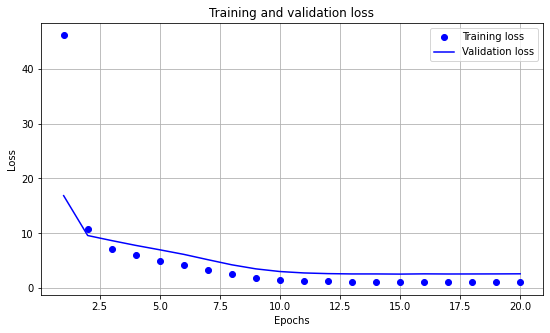

In [57]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

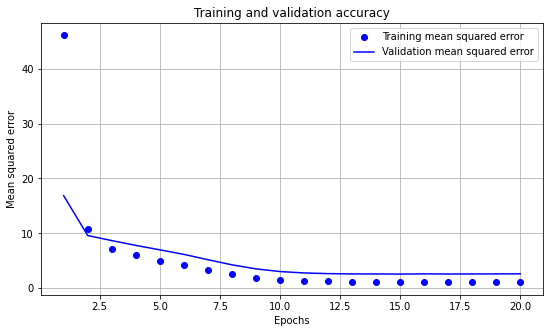

In [59]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [60]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"The Crew is a puzzle-based cooperative trick taking game. Each round is self-contained. The only carryover is the inner-workings of the players. It is all about challenging a group with a puzzle, solving it, then moving on to the next one. The puzzles capture key moments in trick-taking very well--trump timing, protecting nils, bidding tricks, "taking someone home." Through, in a cooperative environment, seizing the moment looses some of its luster. When everyone works together to protect a bid, their is no ongoing challenge to bust another player nor is there the reward of keeping an opponent from busting a partner's nil bid.  What it does to very well, though, is capitalizing on partners' getting on the same wavelength in a trick taking game. This is where the game excels. The Crew doesn't reach the loft heights of team vs. team trick takers like Spades, but serves as an engaging way to challenge the table to a series of bite-sized, mutual puzzles for fans of the genre."
sco

## COMPARE CLASSIFIER VS REGRESSOR

In [118]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Backed on Kickstarter. Yet to play, will update later."
    reg score: 8.16
    clf score: 1

"Which Game First? 11/4/2020 It's on BGA but I think I'm only keen on the idea of playing this in real life."
    reg score: 7.61
    clf score: 0

"+Scythe: Board Extension +Scythe: Modular Board +Scythe: Metal Coins +Scythe: Realistic Resource Tokens  Fantasy Flight Games Sleeves Mayday BASIC Sleeves (70x110) "
    reg score: 10.51
    clf score: 1

"Sounds very interesting to me, I do worry how playing with two people would be"
    reg score: 6.27
    clf score: 1

"I am on the fence.... decision time :-) I have until October I guess to decide"
    reg score: 7.76
    clf score: 1

"Recently bought...waiting to play..."
    reg score: 8.93
    clf score: 1

"A fantastic game with absolutely terrible quality components. For the price, at least put in a cardboard box insert."
    reg score: 6.89
    clf score: 1

"Missed the first Kickstarter and after seeing the plethora of high reviews and

### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [84]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 162886.00 |          8.35 |        3513.00 |
| 167355.00 |          8.42 |        1797.00 |
| 167791.00 |          8.21 |        8228.00 |
| 169427.00 |          8.60 |         222.00 |
| 169786.00 |          8.10 |        7335.00 |


In [85]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [86]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 162886.00 |          8.15 |         309.00 |
| 167355.00 |          8.22 |         217.00 |
| 167791.00 |          8.19 |         439.00 |
| 169427.00 |          8.24 |          71.00 |
| 169786.00 |          8.12 |         591.00 |


In [87]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [88]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/A7IOpPt...","<a href=""https://boardgamegeek.com/boardgame/2...",7.387199,7.973569,7.431562,1,2017
1,"<img src=""https://cf.geekdo-images.com/OcnPGq9...","<a href=""https://boardgamegeek.com/boardgame/3...",7.868293,7.206773,7.728356,2,2021
2,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.234211,8.156118,8.210568,3,2021
3,"<img src=""https://cf.geekdo-images.com/cwUgf-f...","<a href=""https://boardgamegeek.com/boardgame/2...",6.316538,7.972783,7.064295,4,2021
4,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.890744,7.928342,7.894179,5,2020


In [89]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [90]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Fantasy Realms,7.387199,7.973569,7.431562,1,2017
2,,The Adventures of Robin Hood,7.868293,7.206773,7.728356,2,2021
3,,Destinies,8.234211,8.156118,8.210568,3,2021
4,,Frosthaven,6.316538,7.972783,7.064295,4,2021
5,,Lost Ruins of Arnak,7.890744,7.928342,7.894179,5,2020


In [91]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Goonies: Never Say Die,10.000000,NaN,NaN,15,2021
2,,Chronicles of Drunagor: Age of Darkness,9.535714,8.690790,9.418725,39,2021
3,,Eclipse: Second Dawn for the Galaxy,8.744447,8.265730,8.669246,38,2020
4,,Polis,8.741379,7.805540,8.539036,20,2020
5,,Brass: Birmingham,8.683730,8.206855,8.640412,25,2018


In [92]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.535714,8.690790,9.418725,39,2021
2,,Eclipse: Second Dawn for the Galaxy,8.744447,8.265730,8.669246,38,2020
3,,Brass: Birmingham,8.683730,8.206855,8.640412,25,2018
4,,Gloomhaven: Jaws of the Lion,8.598242,8.182595,8.557639,21,2020
5,,Polis,8.741379,7.805540,8.539036,20,2020


In [93]:
# model.save('saved_model\my_model')

In [94]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [95]:
# some examples on "long" comments vs short comments

In [98]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [114]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"I picked up this game after hearing how great it was and was sure it would go well with my group, but wow did it fall flat. I think it took too long for what it was, and while I enjoyed it, it seemed others were ready for it to be over halfway through. "
score: 5.66

"Not played  * Weight: Medium (3.11) * Player count: Community 3-6 / Best 4, 6 * Mechanisms: Area Majority-Influence / Dice Rolling / Grid Movement / Modular Board / Player Elimination / Tile Placement / Variable Phase Order / Variable Player Powers  NEW"
score: 7.12

"Looks like a better fit for Tina and me than LotR:LCG, so going to give it a shot.  CSI-preorder, shipping fall 2016  Received 11/25/2016"
score: 7.17

"When I saw this game I made a joke about it being a deck builder where all the cards are cows. Then that turned out to be true. A herd builder."
score: 7.36

"LI. Very interesting set collection game with bidding and kind of deck builder mechanic. Easy to learn with nice looking components."
score: 7.37

"I